In [1]:
# Imports and initial setup

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
import numpy as np
import pandas as pd
import time
from IPython.display import Image

# Undersampling and Oversampling for class imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import lightgbm as lgb

# Metrics & Corss-Validation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, make_scorer, classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import Markdown, display

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

plt.style.use('fivethirtyeight')

seed = 42



In [4]:
# Print markdown programatically for better visualization.
def printmd(string):
    display(Markdown(string))

In [5]:
# Plots and creates labels for values plotted. Used for exploration of features.
def plot_and_annotate(data, **kwarg):
    ax = data['percent'].sort_values().plot(kind='barh', **kwarg)
    for p in ax.patches:
        width = p.get_width()
        plt.text(5 + width, p.get_y() + 0.55 * p.get_height(),
                 '{:1.2f}%'.format(width),
                 ha='center', va='center')


In [6]:
# Creates percentages for value_counts of a pd.series object.
def create_count_percentages(series, name=None):
    values = series.value_counts()
    expanded_value = values.to_frame(name)
    expanded_value['percent'] = values.apply(lambda _: _ / series.size * 100)
    return expanded_value

In [7]:
# Data must be loaded before definin create_plot_data due to inside reference.
def create_plot_data(data, feature):
    return create_count_percentages(data[feature], name=feature)

In [8]:
def cast_df_features(data, feature_catalog):
    def parse_type(dtype):
        if dtype == 'int':
            return np.int8
        elif dtype == 'float':
            return np.float
        else:
            return dtype

    # Make a dict to use as dtypes for panda's dataframe
    features_dtypes = feature_catalog.set_index('feature_name')['pandas_dtype'].apply(parse_type).to_dict()
    # Keep only the columns that remain in the clean version of the dataframe
    features_dtypes = {k: v for k, v in features_dtypes.items() if k in data.columns}
    return data.astype(features_dtypes)

In [9]:
def create_one_hot_encoding(data, feature_catalog):
    categorical_features = list(feature_catalog[feature_catalog['feature_type'] == 'categorical']['feature_name'])
    categorical_features.remove('crashSeverity')
    categorical_features = list(filter(lambda f: f in data.columns, categorical_features))
    return pd.get_dummies(data, columns=categorical_features)

In [10]:
def structure_and_print_results(model_name, dataset_variation, y_true, y_pred, betta=1, digits=2, average=None):
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    print('Model accuracy: ', accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=digits))

    n_classes = len(precision)
    frame_data = {
        'Model': [model_name] * n_classes,
        'Variation': [dataset_variation] * n_classes,
        'Target': ['F', 'M', 'N', 'S'],
        'Precision': precision,
        'Recall': recall,
        'F1_score': f1
    }
    return pd.DataFrame(frame_data)


In [11]:
# Read original dataset
crash_data = pd.read_csv('data/Crash_Analysis_System_CAS_data_clean.csv')

In [12]:
# Read features descriptions
features_catalog = pd.read_table('data/features_description.tsv')
crash_data = cast_df_features(crash_data, features_catalog)

In [13]:
 available_features = [feature for feature in features_catalog['feature_name'] if feature in crash_data.columns]

 chi2_matrix = []
 index = []

 for feature_a in available_features:
     index.append(feature_a)
     row = []
     for feature_b in available_features:
         contingency = pd.crosstab(crash_data[feature_a],
                                   crash_data[feature_b])
         #acceptance level is 0.05
         p = chi2_contingency(contingency)[1]
         row.append(p)
     chi2_matrix.append(row)

In [14]:
 chi2_p_values = pd.DataFrame(chi2_matrix, columns=index, index=index)
 chi2_p_values.to_csv('chi2_independence_results.csv')

In [15]:
chi2_p_values = pd.read_csv('chi2_independence_results.csv', index_col=0)

In [16]:
chi2_p_values

crashSeverity  crashSHDescription  \
crashSeverity             2.729479e-253        4.502065e-01   
crashSHDescription         4.502065e-01        2.465848e-88   
directionRoleDescription   5.200248e-01        3.757958e-01   
flatHill                   2.128332e-01        3.751120e-02   
holiday                    5.200182e-02        7.395947e-04   
intersection               1.000000e+00        1.000000e+00   
light                      9.311639e-01        8.981540e-01   
roadCharacter              5.413231e-01        1.132265e-02   
roadLane                   9.848918e-01        6.069553e-04   
roadSurface                8.539858e-02        3.226252e-03   
streetLight                4.268389e-01        2.366321e-08   
tlaName                    5.323371e-01        2.002651e-05   
trafficControl             7.478791e-01        1.000000e+00   
urban                      7.069197e-02        7.163079e-23   
weatherA                   8.737235e-01        1.832198e-01   
weatherB                   9.015600e-02        1.070822e-02   
speedLimit                 9.154787e-01        3.025399e-20   
bridge                     7.991283e-01        4.894067e-01   
cliffBank                  3.240665e-01        4.538070e-03   
debris                     9.182038e-01        9.900384e-01   
ditch                      3.612303e-02        4.120308e-01   
fence                      6.829475e-01        2.718368e-03   
guardRail                  9.055857e-01        7.977867e-02   
kerb                       7.279515e-03        6.330156e-01   
objectThrownOrDropped      8.389919e-01        4.674643e-01   
overBank                   1.818793e-02        2.802159e-01   
parkedVehicle              3.798011e-01        1.861927e-06   
phoneBoxEtc                1.294813e-03        2.553482e-01   
postOrPole                 6.997441e-01        2.415566e-02   
roadworks                  7.991283e-01        4.674643e-01   
strayAnimal                7.991283e-01        4.674643e-01   
trafficIsland              1.491641e-01        1.899182e-01   
trafficSign                7.225421e-02        4.657631e-01   
train                      1.000000e+00        1.000000e+00   
tree                       3.019138e-02        8.045577e-01   
vehicle                    7.991283e-01        4.894067e-01   
waterRiver                 3.774761e-01        9.827036e-01   
bicycle                    8.389919e-01        4.894067e-01   
bus                        9.406895e-01        9.827036e-01   
carStationWagon            9.082685e-01        1.615402e-02   
moped                      1.000000e+00        1.000000e+00   
otherVehicleType           9.406895e-01        9.827036e-01   
schoolBus                  1.000000e+00        1.000000e+00   
suv                        8.779397e-01        2.355276e-01   
taxi                       6.783600e-01        2.553482e-01   
truck                      6.694556e-01        1.591719e-01   
unknownVehicleType         1.000000e+00        1.000000e+00   
vanOrUtility               6.921995e-01        8.600350e-01   
pedestrian                 1.394501e-08        2.289712e-01   

                          directionRoleDescription      flatHill  \
crashSeverity                         5.200248e-01  2.128332e-01   
crashSHDescription                    3.757958e-01  3.751120e-02   
directionRoleDescription             2.729479e-253  3.148599e-01   
flatHill                              3.148599e-01  3.128342e-88   
holiday                               8.342705e-01  3.180471e-02   
intersection                          1.000000e+00  1.000000e+00   
light                                 5.273451e-01  2.152352e-01   
roadCharacter                         1.747506e-01  3.724254e-01   
roadLane                              4.493032e-01  5.943076e-01   
roadSurface                           2.395054e-01  9.023074e-01   
streetLight                           7.852782e-01  1.133858e-02   
tlaName                               3.987723e-01  2.15162

In [17]:
crash_data_ohe = create_one_hot_encoding(crash_data, features_catalog)

In [18]:
# Create One Hot Encoding

crash_data = pd.read_csv('Crash_Analysis_System_CAS_data_clean.csv', keep_default_na=False)
features_catalog = pd.read_table('features_description.tsv')
data_ohe = create_one_hot_encoding(crash_data, features_catalog)

In [19]:
# Full dataset variation

y = data_ohe['crashSeverity']
X = data_ohe.drop('crashSeverity', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=seed)
pd.Series(y).value_counts()

Non-Injury Crash    267
Minor Crash          96
Serious Crash        30
Fatal Crash           8
Name: crashSeverity, dtype: int64

In [20]:
for col in set(crash_data.columns) - set(crash_data.describe().columns):
    crash_data[col] = crash_data[col].astype('category')

In [21]:
 crash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bicycle                    401 non-null    int64   
 1   bridge                     401 non-null    int64   
 2   bus                        401 non-null    int64   
 3   carStationWagon            401 non-null    int64   
 4   cliffBank                  401 non-null    int64   
 5   crashDirectionDescription  401 non-null    category
 6   crashSeverity              401 non-null    category
 7   crashSHDescription         401 non-null    category
 8   debris                     401 non-null    int64   
 9   directionRoleDescription   401 non-null    category
 10  ditch                      401 non-null    int64   
 11  fence                      401 non-null    int64   
 12  flatHill                   401 non-null    category
 13  guardRail                  401 non-

In [22]:
np.random.seed(150)

remove_n = 1 #Sample size to remove from original dataset
crash_data =  crash_data
drop_indices = np.random.choice( crash_data.index, remove_n, replace=False)
crash_data_subset =  crash_data.drop(drop_indices)

In [23]:
crash_data_subset.shape
crash_data_subset.head()

bicycle  bridge  bus  carStationWagon  cliffBank crashDirectionDescription  \
0        0       0    0                1          0                     North   
1        0       0    0                0          0                     North   
2        0       0    0                1          0                     North   
3        0       0    0                1          0                     South   
4        0       0    0                0          0                      East   

      crashSeverity crashSHDescription  debris directionRoleDescription  ...  \
0  Non-Injury Crash                Yes       0                     West  ...   
1       Minor Crash                 No       0                    North  ...   
2  Non-Injury Crash                 No       0                    South  ...   
3  Non-Injury Crash                 No       0                    North  ...   
4  Non-Injury Crash                Yes       0                     West  ...   

   train  tree truck  unknownVehicleType  urban  vanOrUtility  vehicle  \
0      0     0     0                   0   Open             0        0   
1      0     0     0                   0   Open             0        0   
2      0     0     0                   0  Urban             0        0   
3      0     0     0                   0   Open             0        0   
4      0     0     0                   0   Open             1        0   

   waterRiver    weatherA     weatherB  
0           0  Heavy rain  Strong wind  
1           0        Fine  Strong wind  
2           0  Heavy rain  Strong wind  
3           0  Light rain  Strong wind  
4           0        Fine        Frost  

[5 rows x 56 columns]

In [24]:
#create a new target variable - Reduced target class from a multi-class classification to a binary classification 
# problem to handle the imbalanced dataset and simplify analysis
 

crash_data.loc[crash_data.crashSeverity!='Non-Injury Crash', 'Target_Severe_Indicator']= 1
crash_data.loc[crash_data.crashSeverity =='Non-Injury Crash','Target_Severe_Indicator']= 0

In [25]:
crash_data.Target_Severe_Indicator.value_counts()

0.0    267
1.0    134
Name: Target_Severe_Indicator, dtype: int64

In [26]:
crash_data_subset= crash_data.drop('crashSeverity', axis=1).copy()

In [27]:
crash_data_X = crash_data_subset.drop('Target_Severe_Indicator', axis=1)  
crash_data_Y = crash_data_subset['Target_Severe_Indicator']

In [28]:
# Converting independent categorical features to Numerical by creating Dummy variables

crash_data_X_dummy = pd.get_dummies(crash_data_X)
#print(dataset_X_dummy.head())

In [29]:
crash_data_X_dummy.shape

(401, 163)

In [30]:
from sklearn.feature_selection import VarianceThreshold

# threshold set to 87% for variance 
# i.e. if 87% of the column data is the same (i.e. low variation), the column will not be as useful
# in the prediction
thresh=(.85 * (1 - .85))

In [31]:
# Wrapper function to identify low variance features and remove them from the dataframe 

def get_low_variance_columns(dframe=None, columns=None,
                             skip_columns=None, thresh=0.0,
                             autoremove=False):
    try:
        # get list of all the original df columns
        all_columns = dframe.columns

        # remove `skip_columns`
        remaining_columns = all_columns.drop(skip_columns)

        # get length of new index
        max_index = len(remaining_columns) - 1

        # get indices for `skip_columns`
        skipped_idx = [all_columns.get_loc(column)
                       for column
                       in skip_columns]

        # adjust insert location by the number of columns removed
        # (for non-zero insertion locations) to keep relative
        # locations intact
        for idx, item in enumerate(skipped_idx):
            if item > max_index:
                diff = item - max_index
                skipped_idx[idx] -= diff
            if item == max_index:
                diff = item - len(skip_columns)
                skipped_idx[idx] -= diff
            if idx == 0:
                skipped_idx[idx] = item

        # get values of `skip_columns`
        skipped_values = dframe.iloc[:, skipped_idx].values

        # get dataframe values
        X = dframe.loc[:, remaining_columns].values

        # instantiate VarianceThreshold object
        vt = VarianceThreshold(threshold=thresh)

        # fit vt to data
        vt.fit(X)

        # get the indices of the features that are being kept
        feature_indices = vt.get_support(indices=True)

        # remove low-variance columns from index
        feature_names = [remaining_columns[idx]
                         for idx, _
                         in enumerate(remaining_columns)
                         if idx
                         in feature_indices]

        # get the columns to be removed
        removed_features = list(np.setdiff1d(remaining_columns,
                                             feature_names))
        print("Found {0} low-variance columns."
              .format(len(removed_features)))

        # remove the columns
        if autoremove:
            print("Removing low-variance features.")
            # remove the low-variance columns
            X_removed = vt.transform(X)

            print("Reassembling the dataframe (with low-variance "
                  "features removed).")
            # re-assemble the dataframe
            dframe = pd.DataFrame(data=X_removed,
                                  columns=feature_names)

            # add back the `skip_columns`
            for idx, index in enumerate(skipped_idx):
                dframe.insert(loc=index,
                              column=skip_columns[idx],
                              value=skipped_values[:, idx])
            print("Succesfully removed low-variance columns.")

        # do not remove columns
        else:
            print("No changes have been made to the dataframe.")

    except Exception as e:
        print(e)
        print("Could not remove low-variance features. Something "
              "went wrong.")
        pass

    return dframe, removed_features

In [32]:
# retrieve new dataframe (with low variance features)
crash_data_new, low_var_col = get_low_variance_columns(crash_data_X_dummy,[],[],thresh, True) 
#Set to True to remove low variance columns

Found 130 low-variance columns.
Removing low-variance features.
Reassembling the dataframe (with low-variance features removed).
Succesfully removed low-variance columns.


In [33]:
crash_data_new.shape

(401, 33)

In [34]:
crash_data_new.head()

carStationWagon  NumberOfLanes  speedLimit  vanOrUtility  \
0              1.0            2.0       100.0           0.0   
1              0.0            2.0       100.0           0.0   
2              1.0            2.0        50.0           0.0   
3              1.0            2.0       100.0           0.0   
4              0.0            2.0       100.0           1.0   

   crashDirectionDescription_East  crashDirectionDescription_North  \
0                             0.0                              1.0   
1                             0.0                              1.0   
2                             0.0                              1.0   
3                             0.0                              0.0   
4                             1.0                              0.0   

   crashDirectionDescription_South  crashDirectionDescription_West  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              1.0                             0.0   
4                              0.0                             0.0   

   crashSHDescription_No  crashSHDescription_Yes  ...  trafficControl_N/A  \
0                    0.0                     1.0  ...                 0.0   
1                    1.0                     0.0  ...                 1.0   
2                    1.0                     0.0  ...                 1.0   
3                    1.0                     0.0  ...                 1.0   
4                    0.0                     1.0  ...                 0.0   

   trafficControl_Nil  trafficControl_Unknown  urban_Open  urban_Urban  \
0                 0.0                     1.0         1.0          0.0   
1                 0.0                     0.0         1.0          0.0   
2                 0.0                     0.0         0.0          1.0   
3                 0.0                     0.0         1.0          0.0   
4                 0.0                     1.0         1.0          0.0   

   weatherA_Fine  weatherA_Heavy rain  weatherA_Light rain  weatherB_Frost  \
0            0.0                  1.0                  0.0             0.0   
1            1.0                  0.0                  0.0             0.0   
2            0.0                  1.0                  0.0             0.0   
3            0.0                  0.0                  1.0             0.0   
4            1.0                  0.0                  0.0             1.0   

   weatherB_Strong wind  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   0.0  

[5 rows x 33 columns]

In [35]:
crash_data_normalized=(crash_data_new-crash_data_new.min())/(crash_data_new.max()-crash_data_new.min())

In [36]:
crash_data_normalized.head()

carStationWagon  NumberOfLanes  speedLimit  vanOrUtility  \
0              0.2           0.25       1.000           0.0   
1              0.0           0.25       1.000           0.0   
2              0.2           0.25       0.375           0.0   
3              0.2           0.25       1.000           0.0   
4              0.0           0.25       1.000           0.5   

   crashDirectionDescription_East  crashDirectionDescription_North  \
0                             0.0                              1.0   
1                             0.0                              1.0   
2                             0.0                              1.0   
3                             0.0                              0.0   
4                             1.0                              0.0   

   crashDirectionDescription_South  crashDirectionDescription_West  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              1.0                             0.0   
4                              0.0                             0.0   

   crashSHDescription_No  crashSHDescription_Yes  ...  trafficControl_N/A  \
0                    0.0                     1.0  ...                 0.0   
1                    1.0                     0.0  ...                 1.0   
2                    1.0                     0.0  ...                 1.0   
3                    1.0                     0.0  ...                 1.0   
4                    0.0                     1.0  ...                 0.0   

   trafficControl_Nil  trafficControl_Unknown  urban_Open  urban_Urban  \
0                 0.0                     1.0         1.0          0.0   
1                 0.0                     0.0         1.0          0.0   
2                 0.0                     0.0         0.0          1.0   
3                 0.0                     0.0         1.0          0.0   
4                 0.0                     1.0         1.0          0.0   

   weatherA_Fine  weatherA_Heavy rain  weatherA_Light rain  weatherB_Frost  \
0            0.0                  1.0                  0.0             0.0   
1            1.0                  0.0                  0.0             0.0   
2            0.0                  1.0                  0.0             0.0   
3            0.0                  0.0                  1.0             0.0   
4            1.0                  0.0                  0.0             1.0   

   weatherB_Strong wind  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   0.0  

[5 rows x 33 columns]

In [37]:
crash_data_X=crash_data_normalized.round(3) 

In [38]:
crash_data_X.head(3)

carStationWagon  NumberOfLanes  speedLimit  vanOrUtility  \
0              0.2           0.25       1.000           0.0   
1              0.0           0.25       1.000           0.0   
2              0.2           0.25       0.375           0.0   

   crashDirectionDescription_East  crashDirectionDescription_North  \
0                             0.0                              1.0   
1                             0.0                              1.0   
2                             0.0                              1.0   

   crashDirectionDescription_South  crashDirectionDescription_West  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   

   crashSHDescription_No  crashSHDescription_Yes  ...  trafficControl_N/A  \
0                    0.0                     1.0  ...                 0.0   
1                    1.0                     0.0  ...                 1.0   
2                    1.0                     0.0  ...                 1.0   

   trafficControl_Nil  trafficControl_Unknown  urban_Open  urban_Urban  \
0                 0.0                     1.0         1.0          0.0   
1                 0.0                     0.0         1.0          0.0   
2                 0.0                     0.0         0.0          1.0   

   weatherA_Fine  weatherA_Heavy rain  weatherA_Light rain  weatherB_Frost  \
0            0.0                  1.0                  0.0             0.0   
1            1.0                  0.0                  0.0             0.0   
2            0.0                  1.0                  0.0             0.0   

   weatherB_Strong wind  
0                   1.0  
1                   1.0  
2                   1.0  

[3 rows x 33 columns]

In [39]:
crash_data_Y.value_counts()

0.0    267
1.0    134
Name: Target_Severe_Indicator, dtype: int64

In [40]:
# 80 train -20 test split
X_train, X_test, y_train, y_test = train_test_split(crash_data_X, crash_data_Y, test_size=0.2, random_state=42)

In [41]:
X_train.shape, y_train.shape

((320, 33), (320,))

In [42]:
X_test.shape, y_test.shape

((81, 33), (81,))

In [43]:
from sklearn.model_selection import KFold,GridSearchCV

In [44]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [45]:
import seaborn as sns

In [46]:
!pip install scikit-plot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [47]:
!pip install rfpimp

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

In [49]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit( X_train, y_train )

RandomForestClassifier(random_state=42)

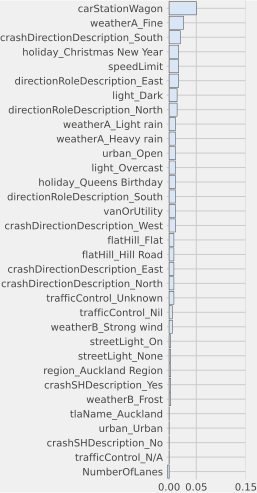

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from rfpimp import *
I = importances(rnd_clf,X_train,y_train)
plot_importances(I)

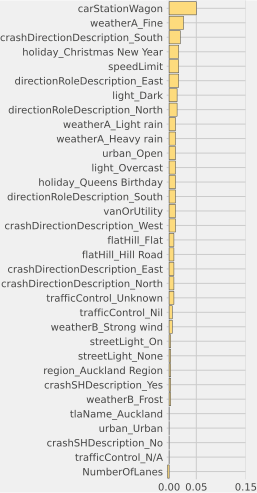

In [51]:
plot_importances(I, color='#FDDB7D')

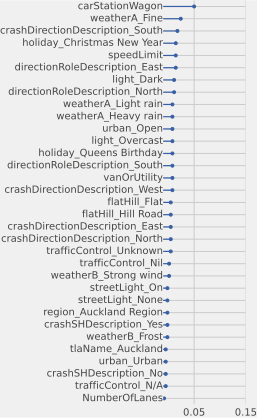

In [52]:
stemplot_importances(I, vscale=.7)

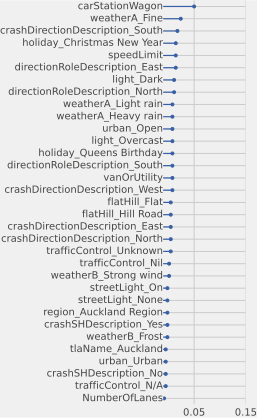

In [53]:
stemplot_importances(I, vscale=.7)

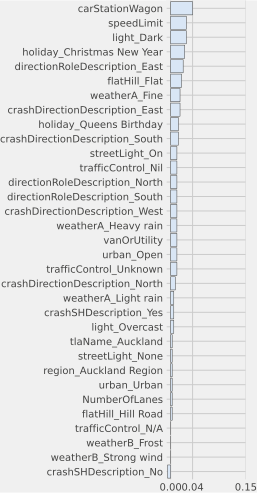

In [54]:
I = importances(rnd_clf,X_train,y_train)
viz = plot_importances(I, title=None)

viz

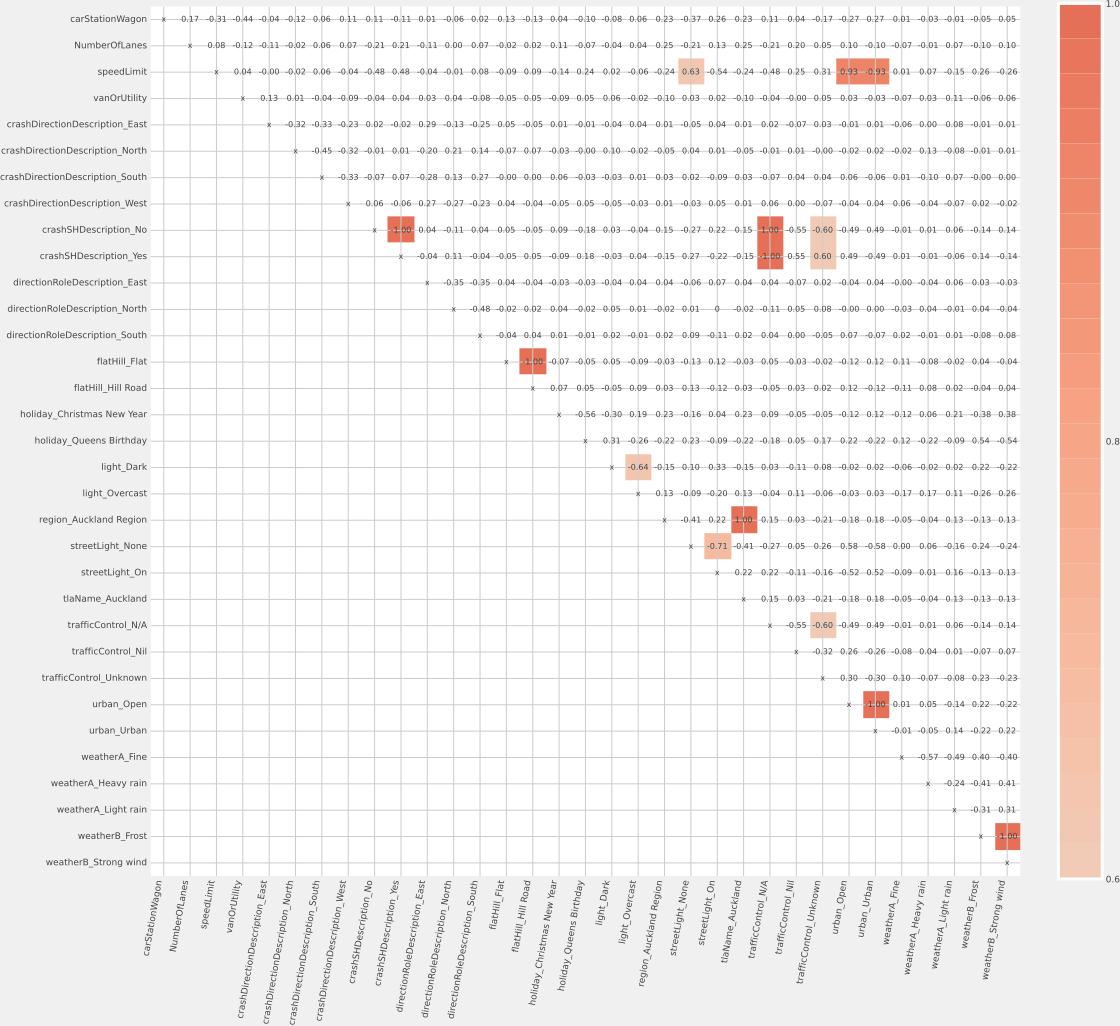

In [55]:
viz = plot_corr_heatmap(X_train, figsize=(16,16))
viz.save('crash_corr.svg')
viz

In [56]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(X_train, sort_by_dependence=True)

In [57]:

D.columns

Index(['Dependence', 'carStationWagon', 'NumberOfLanes', 'speedLimit',
       'vanOrUtility', 'crashDirectionDescription_East',
       'crashDirectionDescription_North', 'crashDirectionDescription_South',
       'crashDirectionDescription_West', 'crashSHDescription_No',
       'crashSHDescription_Yes', 'directionRoleDescription_East',
       'directionRoleDescription_North', 'directionRoleDescription_South',
       'flatHill_Flat', 'flatHill_Hill Road', 'holiday_Christmas New Year',
       'holiday_Queens Birthday', 'light_Dark', 'light_Overcast',
       'region_Auckland Region', 'streetLight_None', 'streetLight_On',
       'tlaName_Auckland', 'trafficControl_N/A', 'trafficControl_Nil',
       'trafficControl_Unknown', 'urban_Open', 'urban_Urban', 'weatherA_Fine',
       'weatherA_Heavy rain', 'weatherA_Light rain', 'weatherB_Frost',
       'weatherB_Strong wind'],
      dtype='object')

In [58]:
D['Dependence'].sort_values(ascending=False)

weatherB_Frost                         1
crashSHDescription_No                  1
urban_Urban                            1
urban_Open                             1
trafficControl_N/A                     1
crashSHDescription_Yes                 1
region_Auckland Region             0.997
weatherB_Strong wind               0.997
trafficControl_Nil                 0.994
tlaName_Auckland                   0.994
flatHill_Flat                      0.994
flatHill_Hill Road                 0.994
trafficControl_Unknown             0.991
crashDirectionDescription_South    0.975
crashDirectionDescription_North    0.969
weatherA_Heavy rain                0.959
streetLight_On                     0.956
crashDirectionDescription_West     0.953
crashDirectionDescription_East     0.944
weatherA_Light rain                0.941
directionRoleDescription_South     0.912
streetLight_None                   0.906
light_Overcast                     0.894
directionRoleDescription_North     0.894
speedLimit      

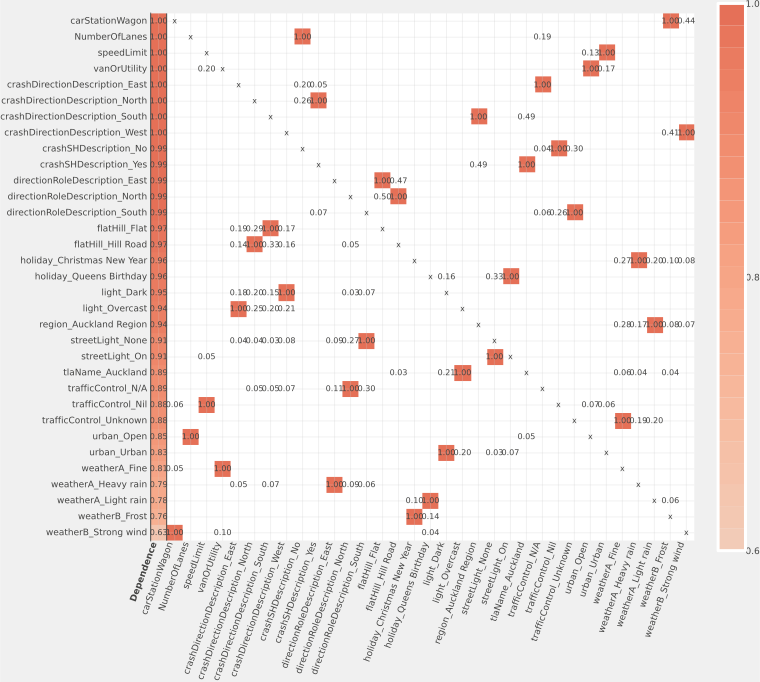

In [59]:
viz = plot_dependence_heatmap(D, figsize=(11,11))
viz.save('crash_dep.svg')
viz

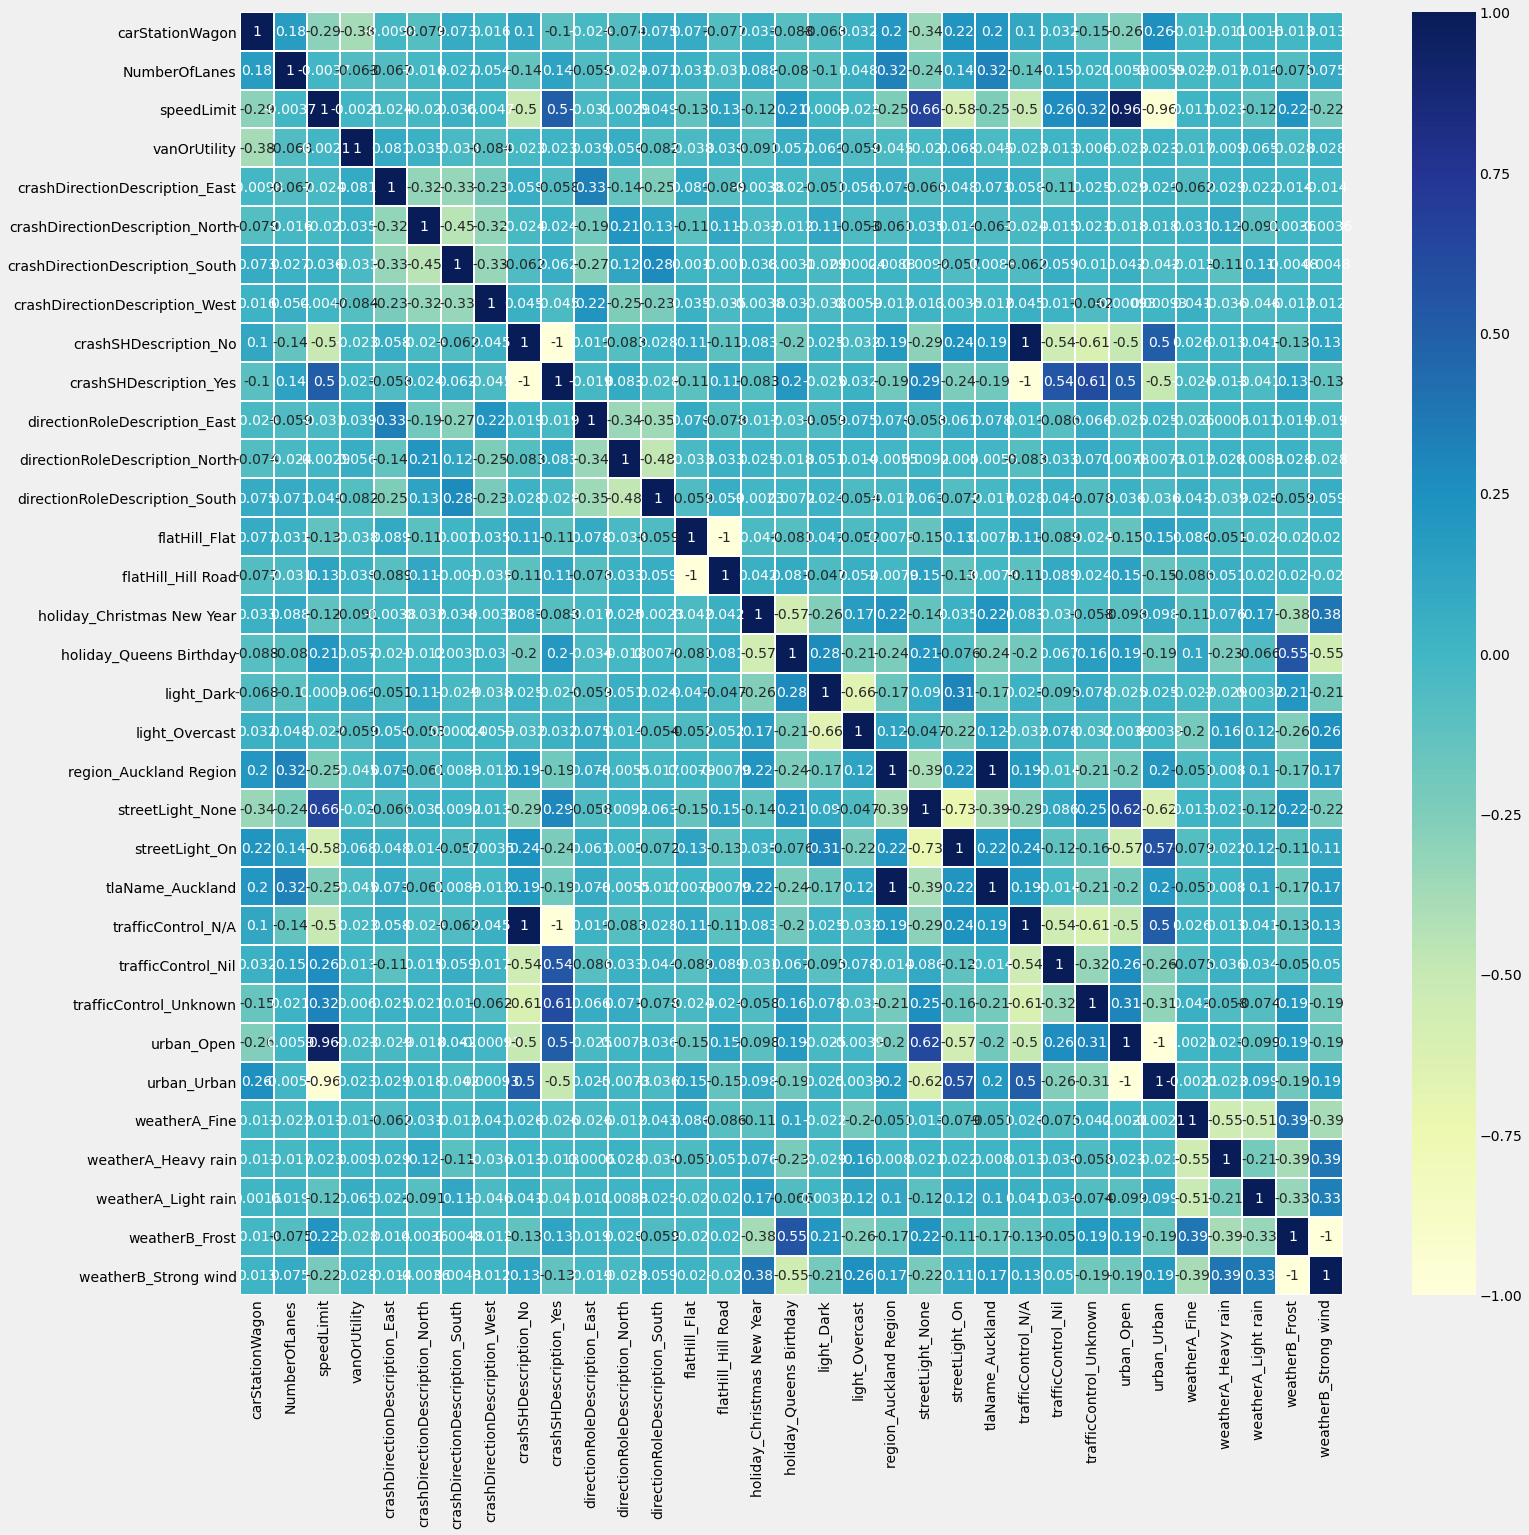

In [60]:
# Calculate correlations
corr = crash_data_X.corr()
# Heatmap
plt.figure(figsize=(22,22))
sns.heatmap(corr, annot=True, linewidths=.2, cmap="YlGnBu");

In [61]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

        
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))        

In [62]:
rfc_clf = RandomForestClassifier(random_state=seed, n_jobs=-1)
rfc_clf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [63]:
print_score(rfc_clf, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.9750

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       212
         1.0       0.98      0.94      0.96       108

    accuracy                           0.97       320
   macro avg       0.98      0.97      0.97       320
weighted avg       0.98      0.97      0.97       320


Confusion Matrix: 
 [[210   2]
 [  6 102]]

Average Accuracy: 	 0.6375
Accuracy SD: 		 0.0508


In [64]:
print_score(rfc_clf, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.6173

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.67      0.87      0.76        55
         1.0       0.22      0.08      0.11        26

    accuracy                           0.62        81
   macro avg       0.44      0.47      0.44        81
weighted avg       0.52      0.62      0.55        81


Confusion Matrix: 
 [[48  7]
 [24  2]]



In [65]:
clf_ADA_base = AdaBoostClassifier(random_state=seed)
clf_ADA_base.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [66]:
print_score(clf_ADA_base, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.6531

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.67      0.93      0.78       212
         1.0       0.44      0.11      0.18       108

    accuracy                           0.65       320
   macro avg       0.56      0.52      0.48       320
weighted avg       0.60      0.65      0.58       320


Confusion Matrix: 
 [[197  15]
 [ 96  12]]

Average Accuracy: 	 0.5875
Accuracy SD: 		 0.0306


In [67]:
print_score(clf_ADA_base, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.6790

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.68      1.00      0.81        55
         1.0       0.00      0.00      0.00        26

    accuracy                           0.68        81
   macro avg       0.34      0.50      0.40        81
weighted avg       0.46      0.68      0.55        81


Confusion Matrix: 
 [[55  0]
 [26  0]]



In [68]:
from sklearn.ensemble import RandomForestClassifier
#class_weight = dict({2:1, 1:15, 0:50})
rdf_clf = RandomForestClassifier(bootstrap=True,
            class_weight="balanced_subsample", 
            criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300,
            oob_score=True,
            random_state=35,
            verbose=0, warm_start=False)
rdf_clf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, oob_score=True, random_state=35)

In [69]:
print_score(rdf_clf, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.8281

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.89      0.85      0.87       212
         1.0       0.73      0.79      0.76       108

    accuracy                           0.83       320
   macro avg       0.81      0.82      0.81       320
weighted avg       0.83      0.83      0.83       320


Confusion Matrix: 
 [[180  32]
 [ 23  85]]

Average Accuracy: 	 0.5719
Accuracy SD: 		 0.0862


In [70]:
print_score(rdf_clf, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.6667

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.68      0.95      0.79        55
         1.0       0.40      0.08      0.13        26

    accuracy                           0.67        81
   macro avg       0.54      0.51      0.46        81
weighted avg       0.59      0.67      0.58        81


Confusion Matrix: 
 [[52  3]
 [24  2]]



In [71]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [72]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression()

In [73]:
print_score(logisticRegr, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.6469

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.67      0.92      0.78       212
         1.0       0.41      0.10      0.16       108

    accuracy                           0.65       320
   macro avg       0.54      0.51      0.47       320
weighted avg       0.58      0.65      0.57       320


Confusion Matrix: 
 [[196  16]
 [ 97  11]]

Average Accuracy: 	 0.5969
Accuracy SD: 		 0.0430


In [74]:
print_score(logisticRegr, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.6790

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.68      1.00      0.81        55
         1.0       0.00      0.00      0.00        26

    accuracy                           0.68        81
   macro avg       0.34      0.50      0.40        81
weighted avg       0.46      0.68      0.55        81


Confusion Matrix: 
 [[55  0]
 [26  0]]



In [75]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

y_pred = gbc.fit(X_train, y_train.values.ravel()).predict(X_test)

In [76]:
print_score(gbc, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.8625

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.84      0.98      0.90       212
         1.0       0.93      0.64      0.76       108

    accuracy                           0.86       320
   macro avg       0.89      0.81      0.83       320
weighted avg       0.87      0.86      0.85       320


Confusion Matrix: 
 [[207   5]
 [ 39  69]]

Average Accuracy: 	 0.6219
Accuracy SD: 		 0.0567


In [77]:
print_score(gbc, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.7037

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.71      0.96      0.82        55
         1.0       0.67      0.15      0.25        26

    accuracy                           0.70        81
   macro avg       0.69      0.56      0.53        81
weighted avg       0.69      0.70      0.63        81


Confusion Matrix: 
 [[53  2]
 [22  4]]



In [78]:
# import the class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (with the default parameters)
knn = KNeighborsClassifier(n_neighbors=3,weights='distance')

# fit the model with data (occurs in-place)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [79]:
print_score(knn, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.9750

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       212
         1.0       1.00      0.93      0.96       108

    accuracy                           0.97       320
   macro avg       0.98      0.96      0.97       320
weighted avg       0.98      0.97      0.97       320


Confusion Matrix: 
 [[212   0]
 [  8 100]]

Average Accuracy: 	 0.6031
Accuracy SD: 		 0.0938


In [80]:
print_score(knn, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.6543

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.68      0.93      0.78        55
         1.0       0.33      0.08      0.12        26

    accuracy                           0.65        81
   macro avg       0.51      0.50      0.45        81
weighted avg       0.57      0.65      0.57        81


Confusion Matrix: 
 [[51  4]
 [24  2]]



In [81]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate =0.07, n_estimators=300,
                      class_weight="balanced_subsample",
                      max_depth=8, min_child_weight=1,
                      scale_pos_weight=7,
                      seed=27,subsample=0.8,colsample_bytree=0.8)

model.fit(X_train,y_train)

[12:02:46] WARNING: /workspace/src/learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree',
              class_weight='balanced_subsample', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=27,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [82]:
print_score(model, X_train, y_train, X_test, y_test, train=True)

Train Result:

accuracy score: 0.9750

Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       212
         1.0       0.93      1.00      0.96       108

    accuracy                           0.97       320
   macro avg       0.97      0.98      0.97       320
weighted avg       0.98      0.97      0.98       320


Confusion Matrix: 
 [[204   8]
 [  0 108]]

[12:07:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:12:08] WARNING: /workspace/src/learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or

In [83]:
print_score(model, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.6173

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.70      0.76      0.73        55
         1.0       0.38      0.31      0.34        26

    accuracy                           0.62        81
   macro avg       0.54      0.54      0.54        81
weighted avg       0.60      0.62      0.61        81


Confusion Matrix: 
 [[42 13]
 [18  8]]



In [84]:
from matplotlib import pyplot
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_tree
lgbm_clf = LGBMClassifier(learning_rate =0.03, max_depth=40, min_data_in_leaf=10,
                   n_estimators=500, num_leaves=50, random_state = 42)
lgbm_clf.fit(X_train,y_train)


LGBMClassifier(learning_rate=0.03, max_depth=40, min_data_in_leaf=10,
               n_estimators=500, num_leaves=50, random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

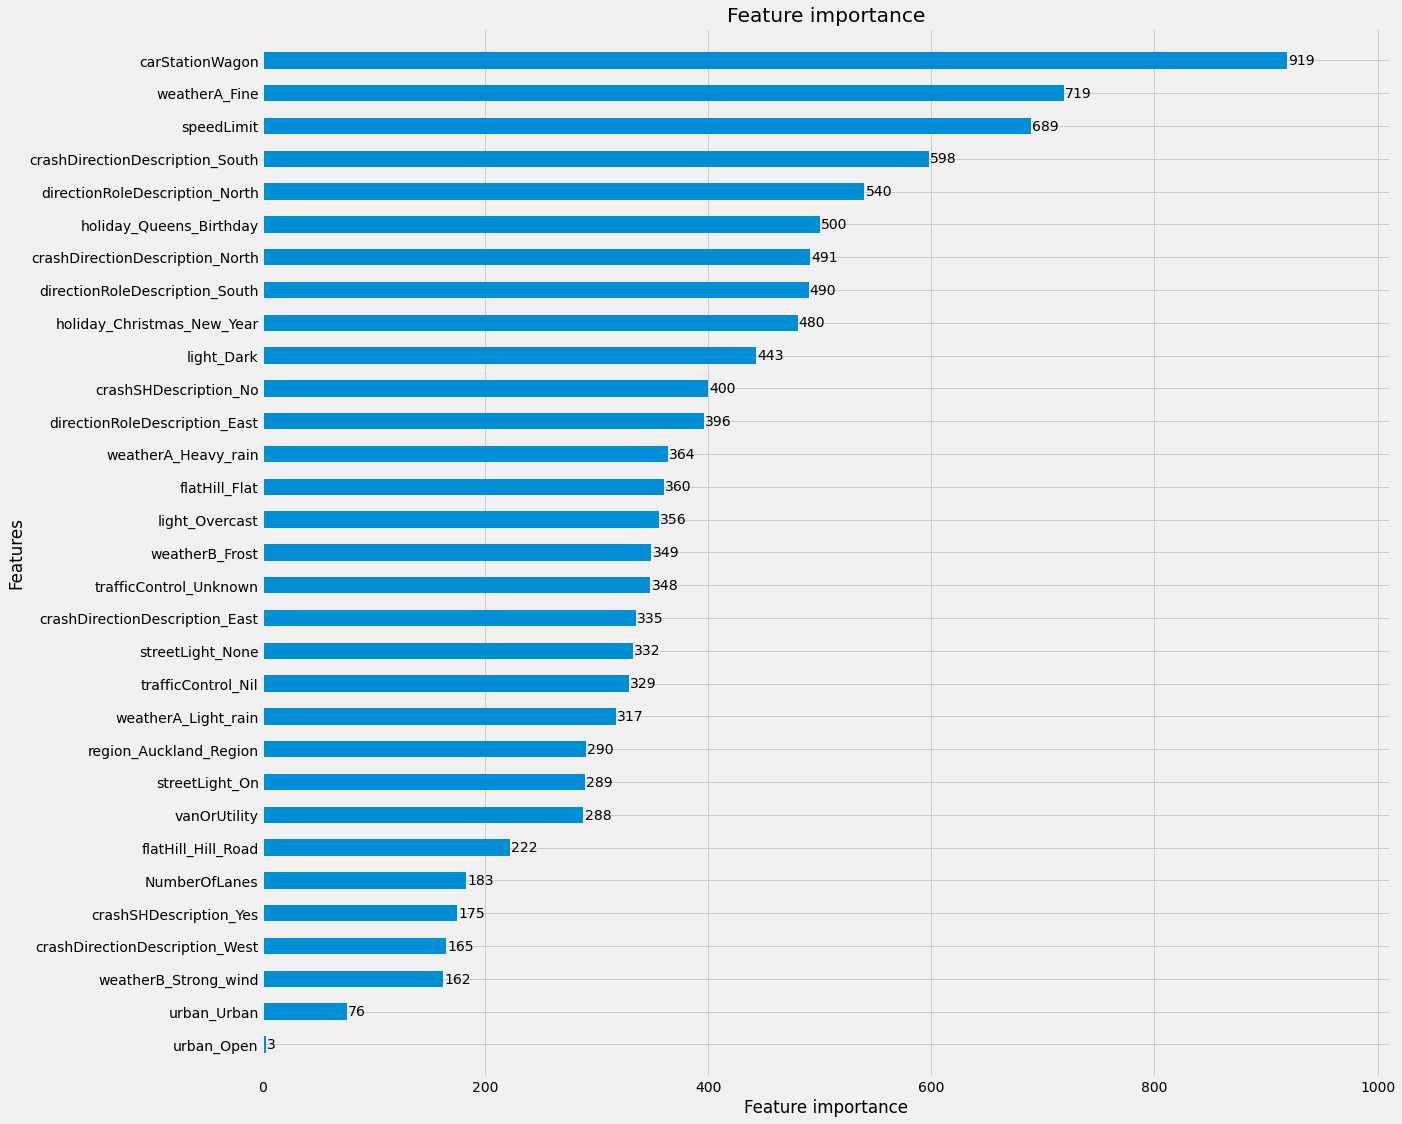

In [85]:
plot_importance(lgbm_clf,height=0.5,figsize=(18,18))

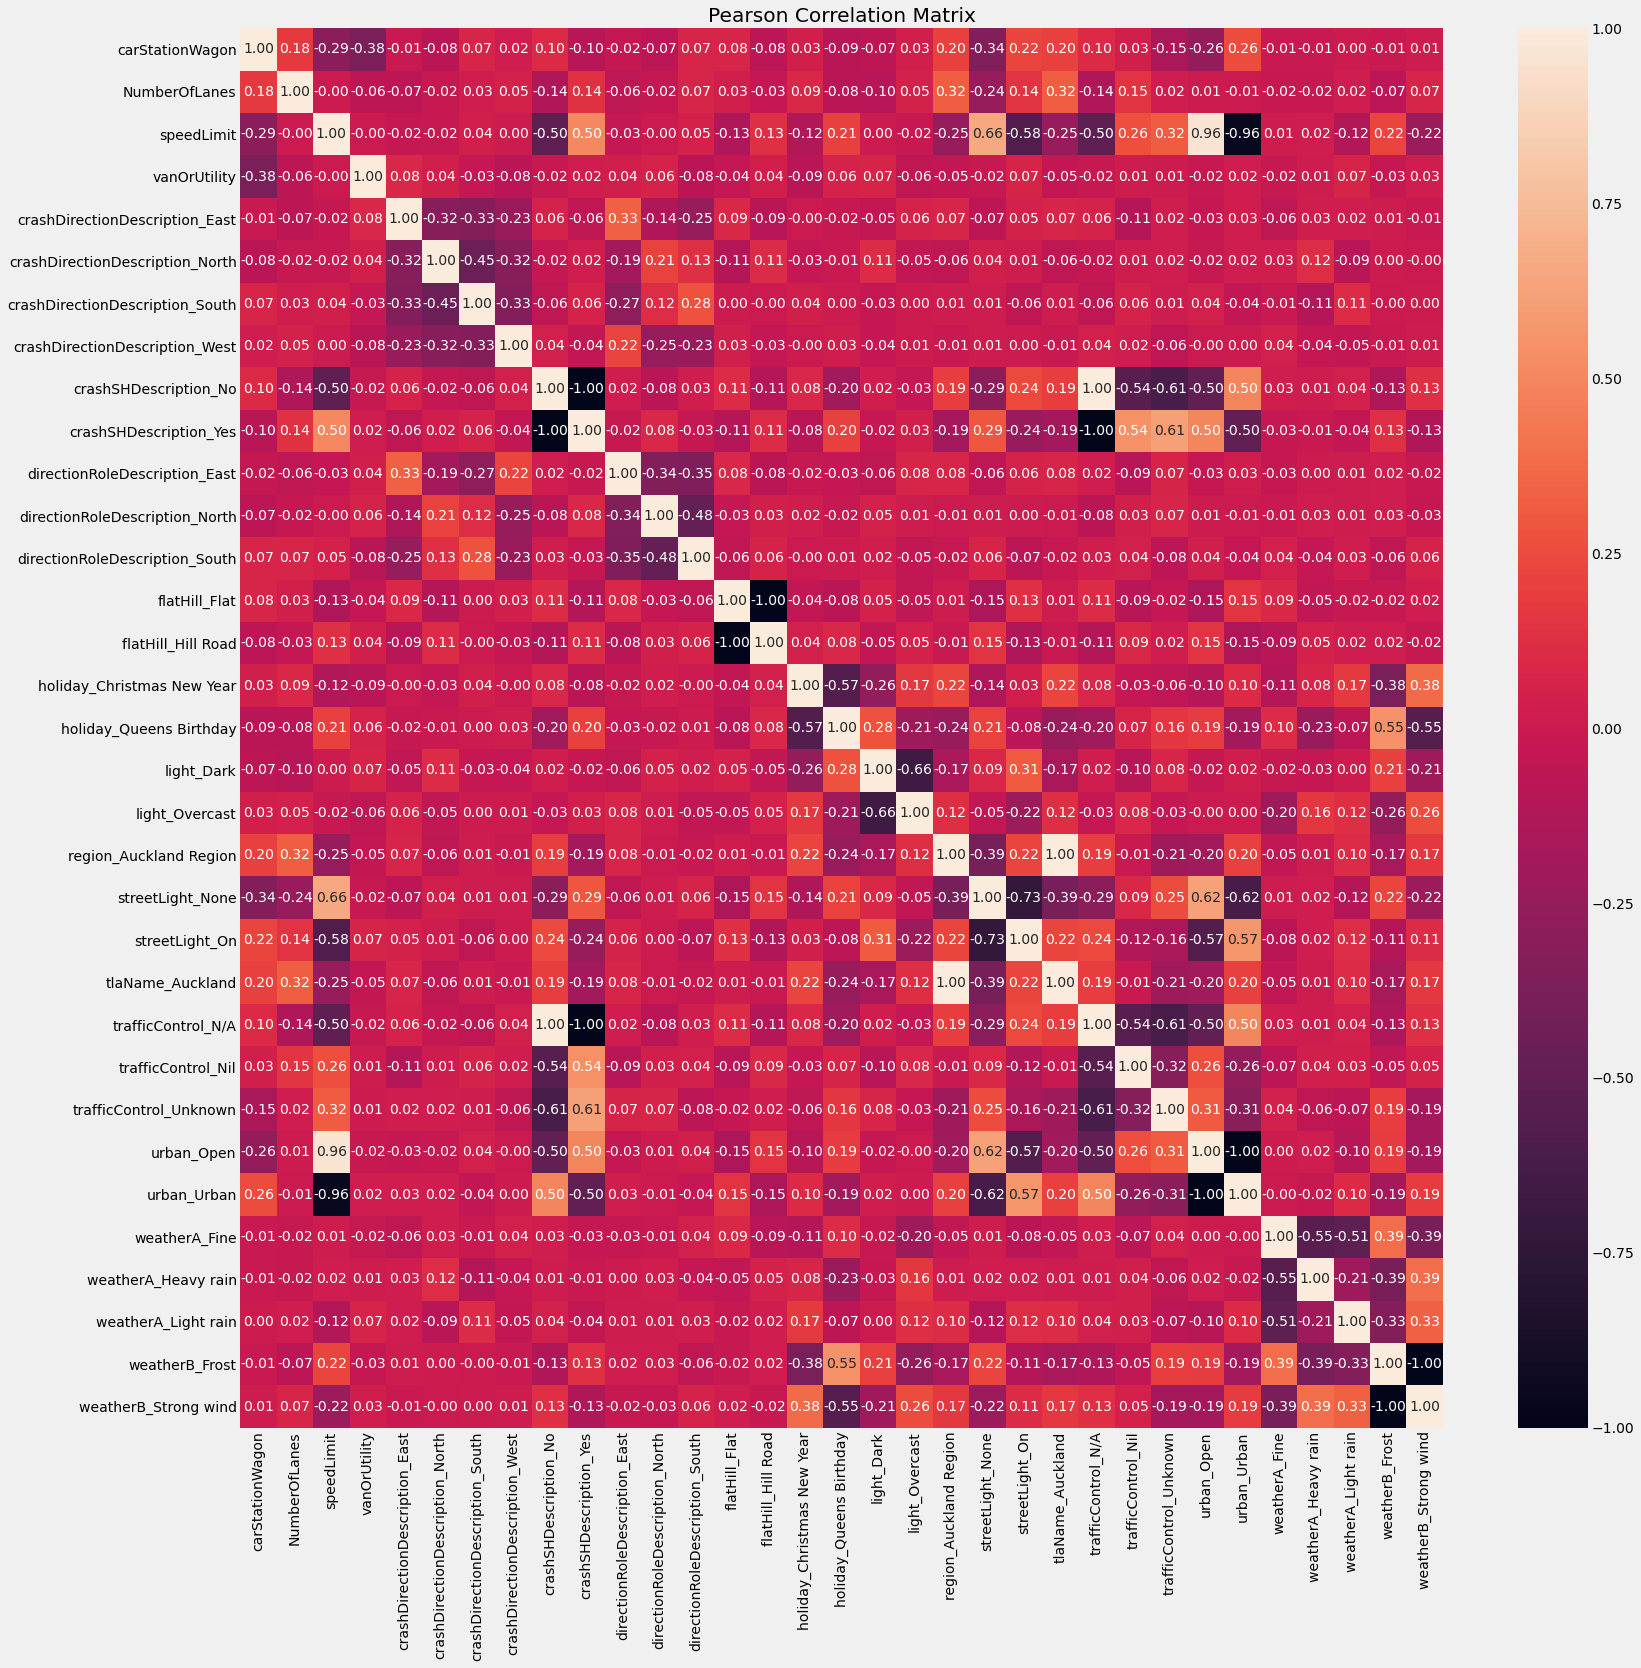

In [86]:
# Plot Pearson correlation matrix

correlations = crash_data_X.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

# Machine learning models

# XGBoost

In [87]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate =0.07, n_estimators=300,
                      class_weight="balanced_subsample",
                      max_depth=8, min_child_weight=1,
                      scale_pos_weight=7,
                      seed=27,subsample=0.8,colsample_bytree=0.8)

model.fit(X_train,y_train)
# Predict on testing set
pred_y_0 = model.predict(X_test)
print(format(classification_report(y_test, pred_y_0)))
print(accuracy_score(y_test, pred_y_0))

[12:17:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73        55
         1.0       0.38      0.31      0.34        26

    accuracy                           0.62        81
   macro avg       0.54      0.54      0.54        81
weighted avg       0.60      0.62      0.61        81

0.6172839506172839


Random (chance) Prediction: AUROC = 0.500
XGBoost: AUROC = 0.609


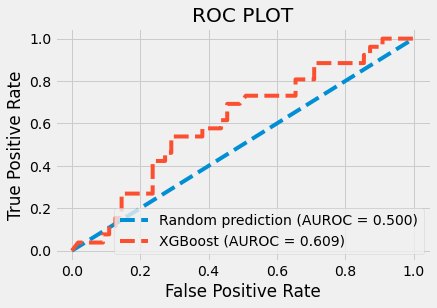

In [88]:
from sklearn.metrics import roc_curve, roc_auc_score
r_probs = [0 for _ in range(len(y_test))]
prob_y_12 = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
prob_y_12 = [p[1] for p in prob_y_12]

r_auc = roc_auc_score(y_test, r_probs)
auc1 = roc_auc_score(y_test, prob_y_12)

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('XGBoost: AUROC = %.3f' % (auc1))

r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
prob_y_12_fpr, prob_y_12_tpr, _ = roc_curve(y_test, prob_y_12)
import matplotlib.pyplot as plt
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(prob_y_12_fpr, prob_y_12_tpr, linestyle='--', label='XGBoost (AUROC = %0.3f)' % auc1)


# Title
plt.title('ROC PLOT')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# K Nearest Neighbor

In [89]:
# import the class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (with the default parameters)
knn = KNeighborsClassifier(n_neighbors=3,weights='distance')

# fit the model with data (occurs in-place)
knn.fit(X_train, y_train)
pred_y_1 = knn.predict(X_test)
print(format(classification_report(y_test, pred_y_1)))
print(accuracy_score(y_test, pred_y_1))

              precision    recall  f1-score   support

         0.0       0.68      0.93      0.78        55
         1.0       0.33      0.08      0.12        26

    accuracy                           0.65        81
   macro avg       0.51      0.50      0.45        81
weighted avg       0.57      0.65      0.57        81

0.654320987654321


Random (chance) Prediction: AUROC = 0.500
KNeighbors Classifier: AUROC = 0.548


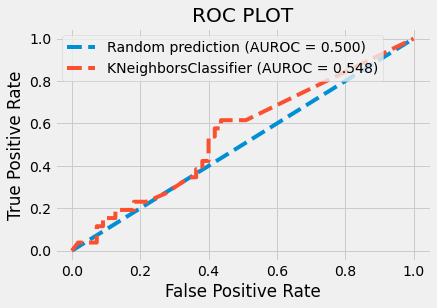

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score
r_probs = [0 for _ in range(len(y_test))]
prob_y_13 = knn.predict_proba(X_test)

# keep probabilities for the positive outcome only
prob_y_13 = [p[1] for p in prob_y_13]

r_auc = roc_auc_score(y_test, r_probs)
auc1 = roc_auc_score(y_test, prob_y_13)

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('KNeighbors Classifier: AUROC = %.3f' % (auc1))

r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
prob_y_13_fpr, prob_y_13_tpr, _ = roc_curve(y_test, prob_y_13)
import matplotlib.pyplot as plt
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(prob_y_13_fpr, prob_y_13_tpr, linestyle='--', label='KNeighborsClassifier (AUROC = %0.3f)' % auc1)


# Title
plt.title('ROC PLOT')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# AdaBoost

In [91]:
clf_ADA_base = AdaBoostClassifier(random_state=seed)
clf_ADA_base.fit(X_train, y_train)
pred_y_2 = clf_ADA_base.predict(X_test)
print(format(classification_report(y_test, pred_y_2)))
print(accuracy_score(y_test, pred_y_2))

              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81        55
         1.0       0.00      0.00      0.00        26

    accuracy                           0.68        81
   macro avg       0.34      0.50      0.40        81
weighted avg       0.46      0.68      0.55        81

0.6790123456790124


Random (chance) Prediction: AUROC = 0.500
AdaBoost Classifier: AUROC = 0.562


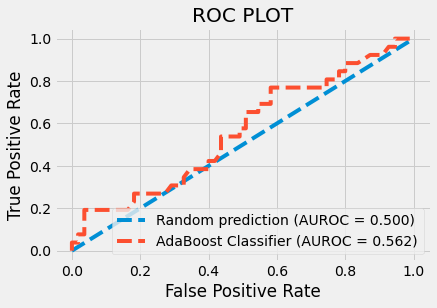

In [92]:
from sklearn.metrics import roc_curve, roc_auc_score
r_probs = [0 for _ in range(len(y_test))]
prob_y_14 = clf_ADA_base.predict_proba(X_test)

# keep probabilities for the positive outcome only
prob_y_14 = [p[1] for p in prob_y_14]

r_auc = roc_auc_score(y_test, r_probs)
auc1 = roc_auc_score(y_test, prob_y_14)

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('AdaBoost Classifier: AUROC = %.3f' % (auc1))

r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
prob_y_14_fpr, prob_y_14_tpr, _ = roc_curve(y_test, prob_y_14)
import matplotlib.pyplot as plt
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(prob_y_14_fpr, prob_y_14_tpr, linestyle='--', label='AdaBoost Classifier (AUROC = %0.3f)' % auc1)


# Title
plt.title('ROC PLOT')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Gradient Boosting Classifier

In [93]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

y_pred = gbc.fit(X_train, y_train.values.ravel()).predict(X_test)
print(format(classification_report(y_test, y_pred)))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82        55
         1.0       0.71      0.19      0.30        26

    accuracy                           0.72        81
   macro avg       0.72      0.58      0.56        81
weighted avg       0.72      0.72      0.66        81

0.7160493827160493


Random (chance) Prediction: AUROC = 0.500
Gradient Boosting Classifier: AUROC = 0.583


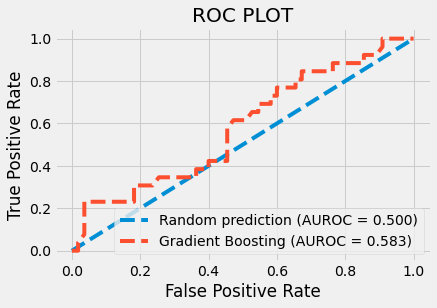

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score
r_probs = [0 for _ in range(len(y_test))]
prob_y_15 = gbc.predict_proba(X_test)

# keep probabilities for the positive outcome only
prob_y_15 = [p[1] for p in prob_y_15]

r_auc = roc_auc_score(y_test, r_probs)
auc1 = roc_auc_score(y_test, prob_y_15)

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Gradient Boosting Classifier: AUROC = %.3f' % (auc1))

r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
prob_y_15_fpr, prob_y_15_tpr, _ = roc_curve(y_test, prob_y_15)
import matplotlib.pyplot as plt
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(prob_y_15_fpr, prob_y_15_tpr, linestyle='--', label='Gradient Boosting (AUROC = %0.3f)' % auc1)


# Title
plt.title('ROC PLOT')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [95]:
import shap
import xgboost

In [96]:
import xgboost
import shap

# train XGBoost model
model = xgboost.XGBClassifier().fit(X_train, y_train)

# compute SHAP values
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

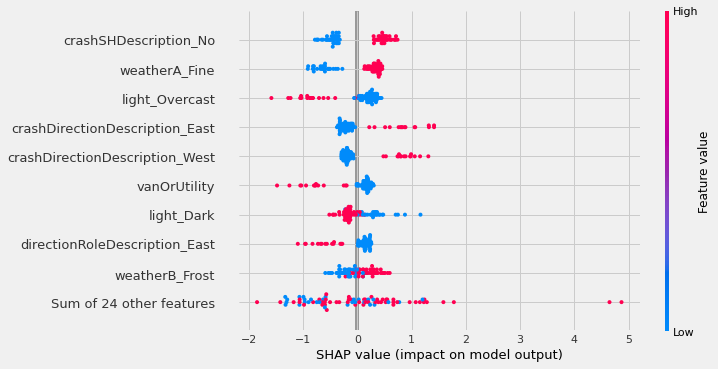

In [97]:
shap.plots.beeswarm(shap_values)

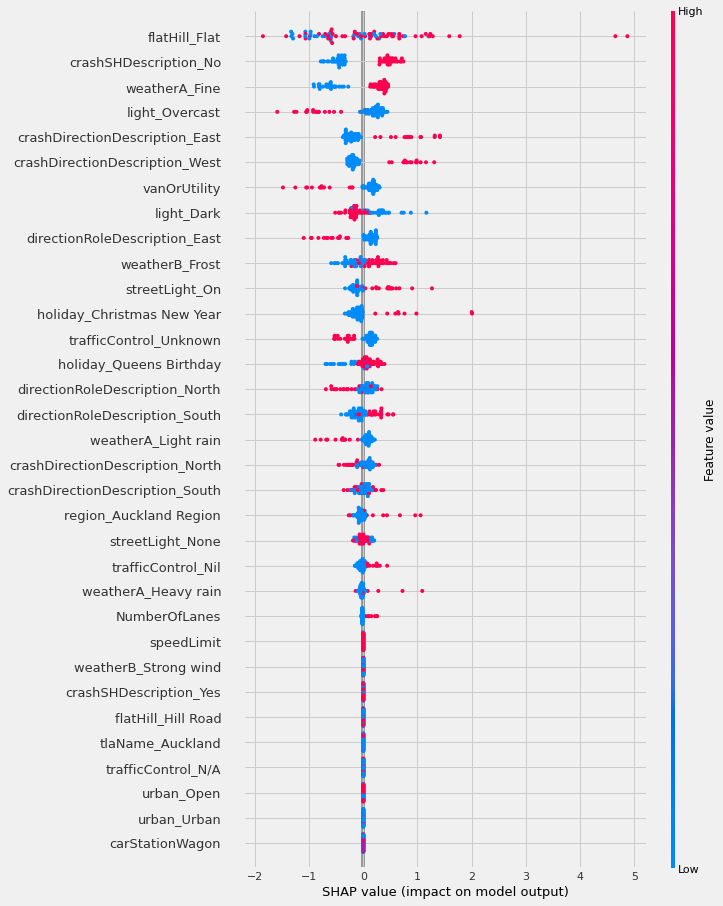

In [98]:
shap.summary_plot(shap_values, X_test, show=False, max_display=X.shape[1])

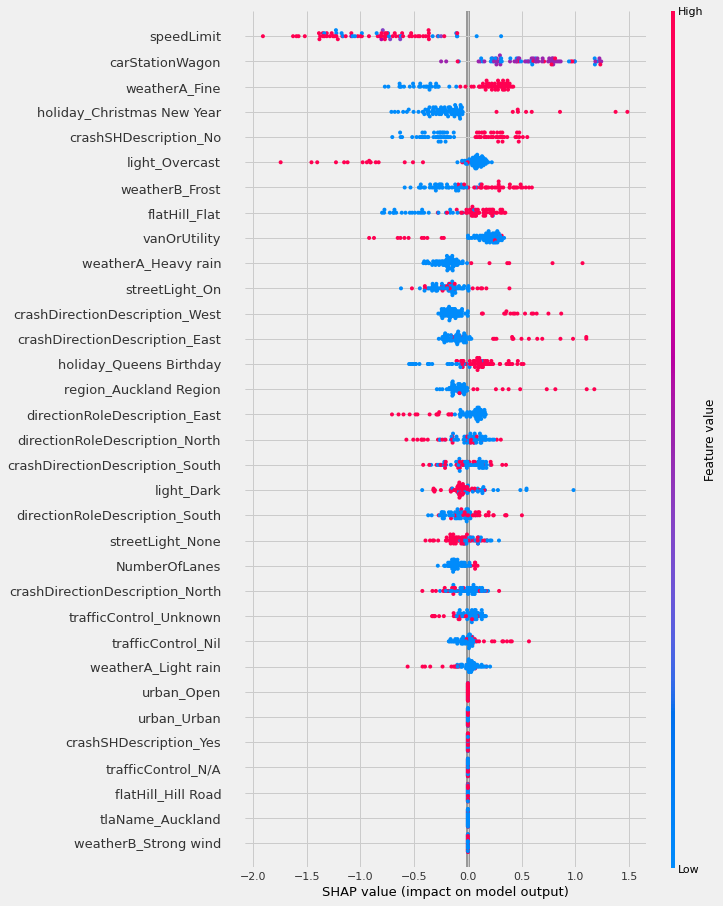

In [99]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
#shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values, X_test, show=False, max_display=X.shape[1])

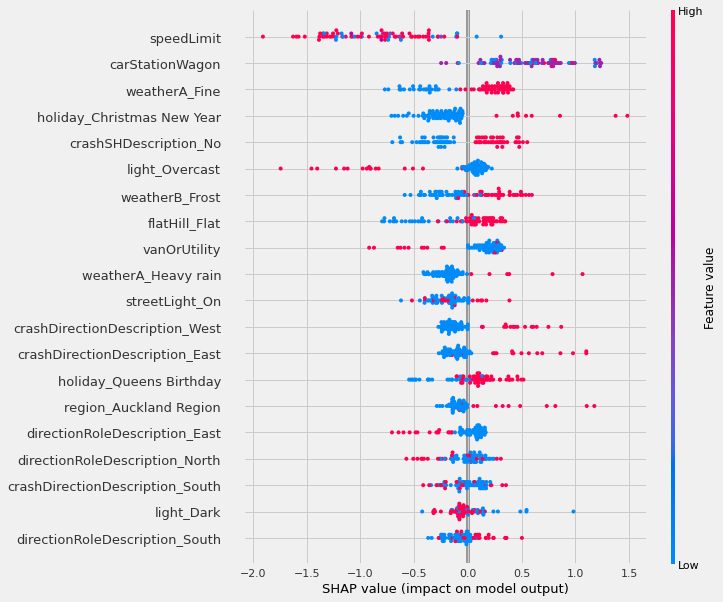

In [101]:
# Plot summary_plot
shap.summary_plot(shap_values, X_test)

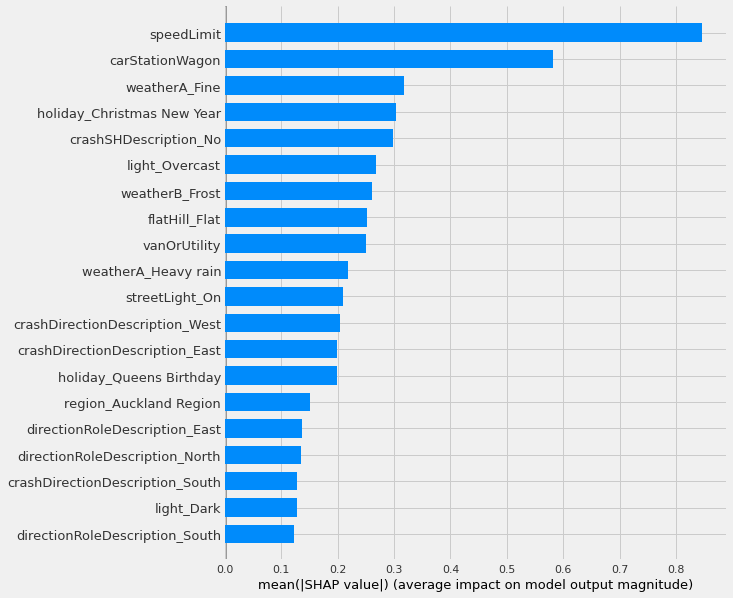

In [102]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [103]:
X_test.speedLimit.value_counts()

1.000    55
0.375    18
0.625     4
0.750     3
0.000     1
Name: speedLimit, dtype: int64

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 18.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 55.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.

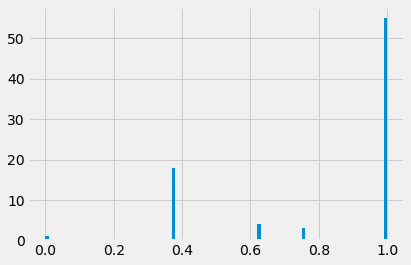

In [104]:
plt.hist(X_test.speedLimit, bins=100)

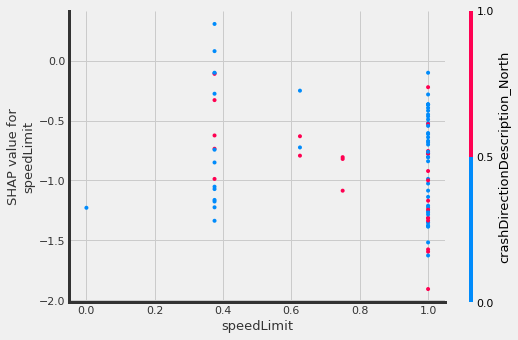

In [105]:
shap.dependence_plot("speedLimit", shap_values, X_test)

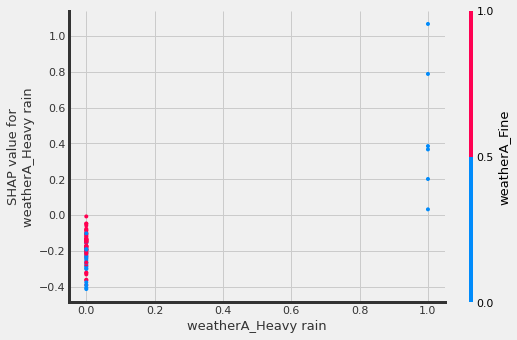

In [106]:
shap.dependence_plot("weatherA_Heavy rain", shap_values, X_test)

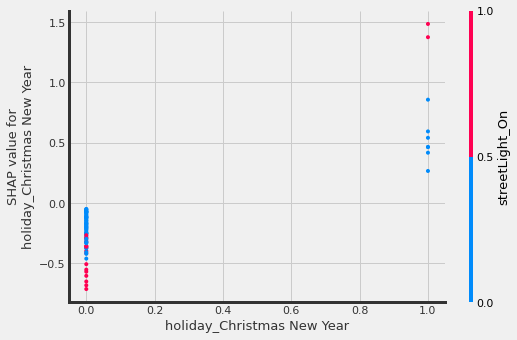

In [110]:
shap.dependence_plot("holiday_Christmas New Year", shap_values, X_test)

In [112]:
X_interaction = X_test.iloc[:500,:]

shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_interaction)

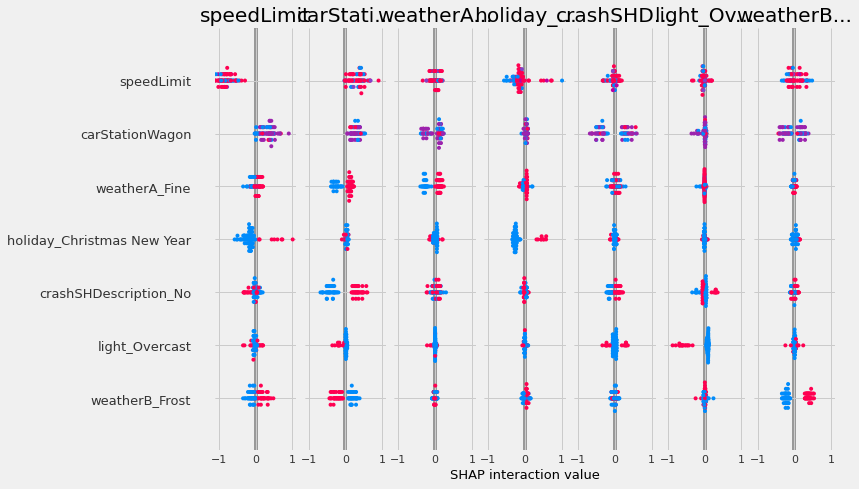

In [113]:
shap.summary_plot(shap_interaction_values, X_test)

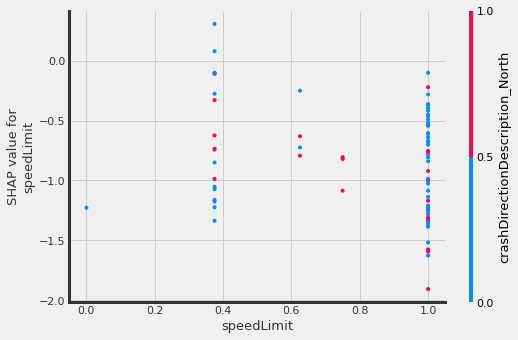

In [114]:
# Raw dependence plot:

shap.dependence_plot(
    "speedLimit",
    shap_values, X_test)

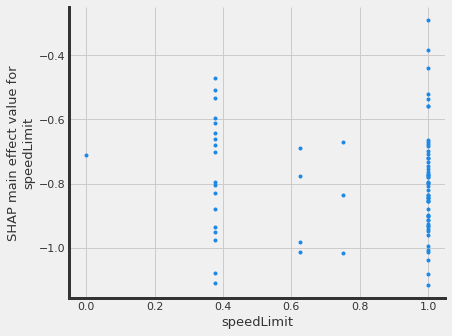

In [115]:
# Interaction values dependence plot capturing main effects:

shap.dependence_plot(
    ("speedLimit", "speedLimit"),
    shap_interaction_values, X_test)

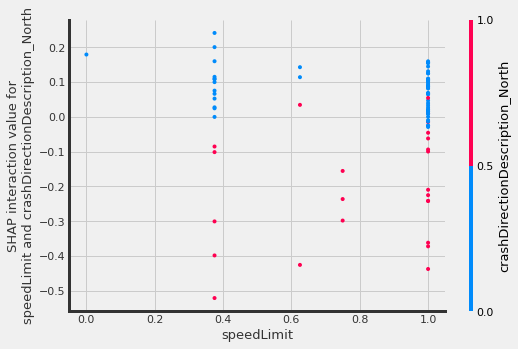

In [116]:
# Interaction values dependence plot capturing interaction effects:

shap.dependence_plot(
    ("speedLimit", "crashDirectionDescription_North"),
    shap_interaction_values, X_test)

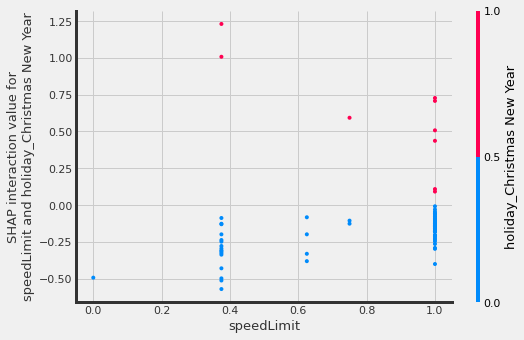

In [127]:
# Interaction values dependence plot capturing interaction effects:

shap.dependence_plot(
    ("speedLimit", "holiday_Christmas New Year"),
    shap_interaction_values, X_test)

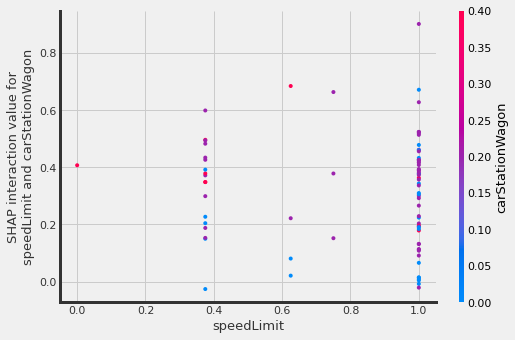

In [128]:
# Interaction values dependence plot capturing interaction effects:

shap.dependence_plot(
    ("speedLimit", "carStationWagon"),
    shap_interaction_values, X_test)

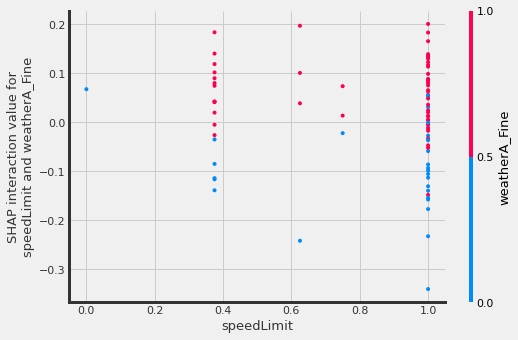

In [129]:
# Interaction values dependence plot capturing interaction effects:

shap.dependence_plot(
    ("speedLimit", "weatherA_Fine"),
    shap_interaction_values, X_test)

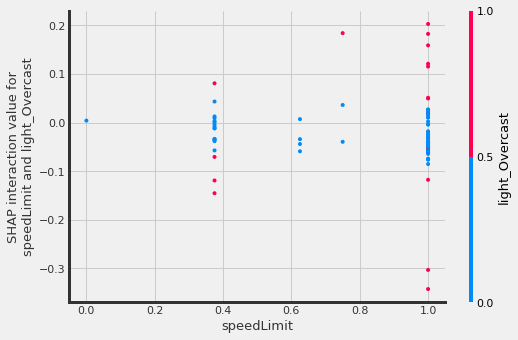

In [130]:
# Interaction values dependence plot capturing interaction effects:

shap.dependence_plot(
    ("speedLimit", "light_Overcast"),
    shap_interaction_values, X_test)

In [117]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

column_name shap_importance
2                        speedLimit           0.846
0                   carStationWagon           0.582
28                    weatherA_Fine           0.318
15       holiday_Christmas New Year           0.304
8             crashSHDescription_No           0.298
18                   light_Overcast           0.268
31                   weatherB_Frost           0.261
13                    flatHill_Flat           0.252
3                      vanOrUtility            0.25
29              weatherA_Heavy rain           0.219
21                   streetLight_On            0.21
7    crashDirectionDescription_West           0.205
4    crashDirectionDescription_East           0.199
16          holiday_Queens Birthday           0.198
19           region_Auckland Region           0.151
10    directionRoleDescription_East           0.137
11   directionRoleDescription_North           0.136
6   crashDirectionDescription_South           0.128
17                       light_Dark           0.128
12   directionRoleDescription_South           0.123
20                 streetLight_None           0.112
1                     NumberOfLanes            0.11
5   crashDirectionDescription_North           0.103
25           trafficControl_Unknown          0.0899
24               trafficControl_Nil          0.0848
30              weatherA_Light rain          0.0799
14               flatHill_Hill Road               0
9            crashSHDescription_Yes               0
23               trafficControl_N/A               0
27                      urban_Urban               0
26                       urban_Open               0
22                 tlaName_Auckland               0
32             weatherB_Strong wind               0

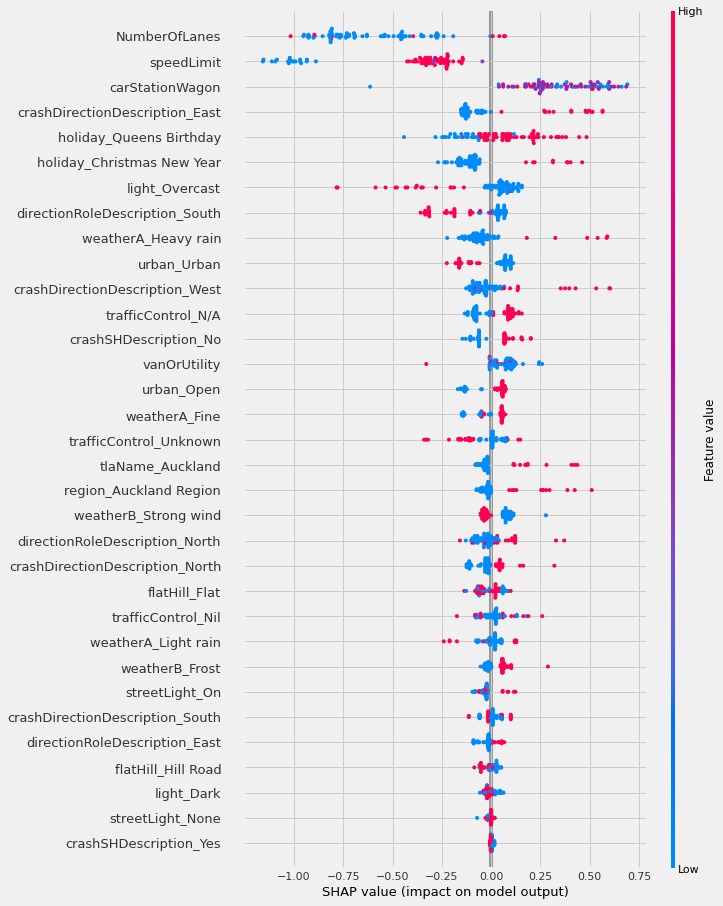

In [118]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(gbc)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
#shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values, X_test, show=False, max_display=X.shape[1])

In [119]:
import xgboost
import shap

# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_train, y_train)

# compute SHAP values
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test[:1000])

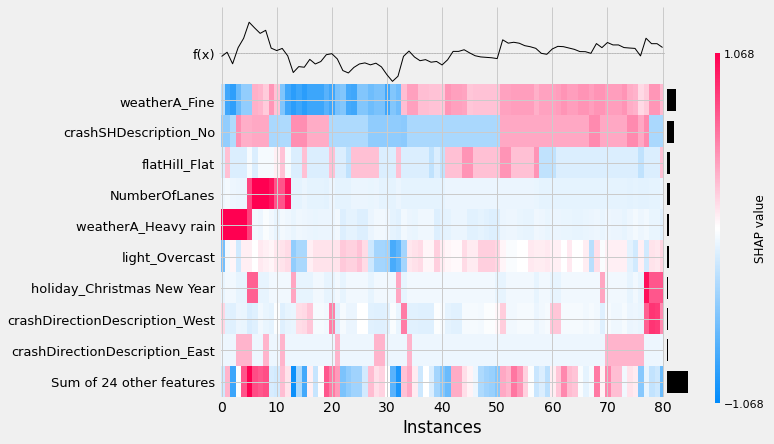

In [120]:
shap.plots.heatmap(shap_values)

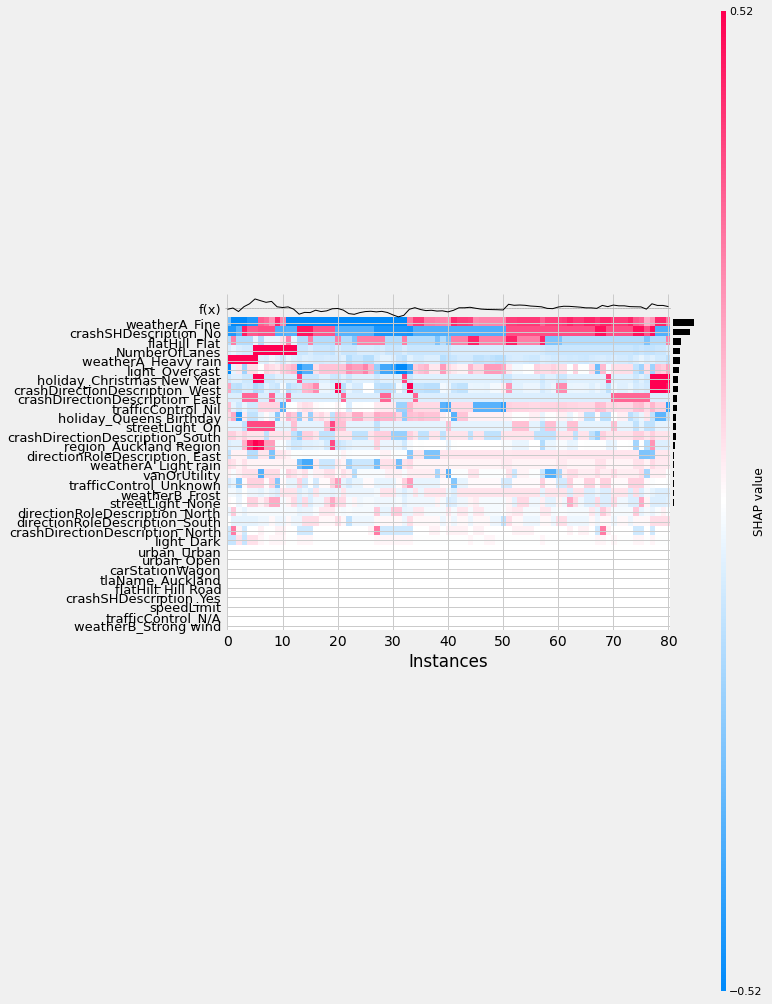

In [121]:
shap.plots.heatmap(shap_values, max_display=33)

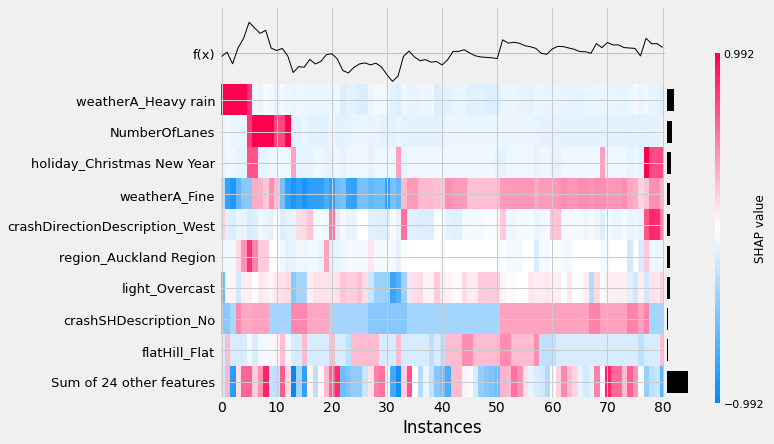

In [122]:
shap.plots.heatmap(shap_values, feature_values=shap_values.abs.max(0))

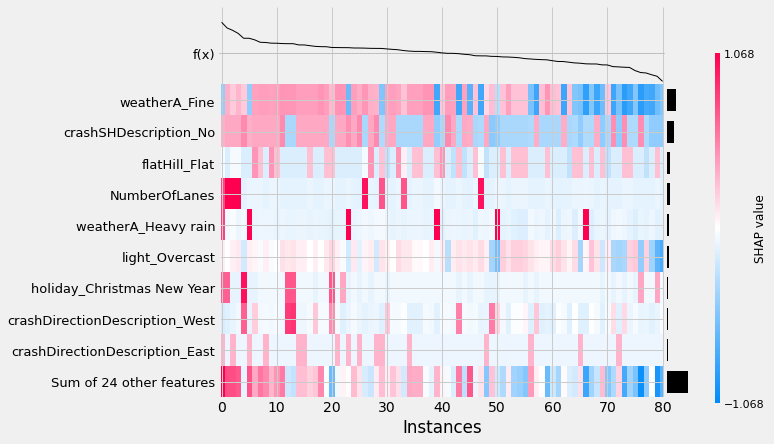

In [123]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

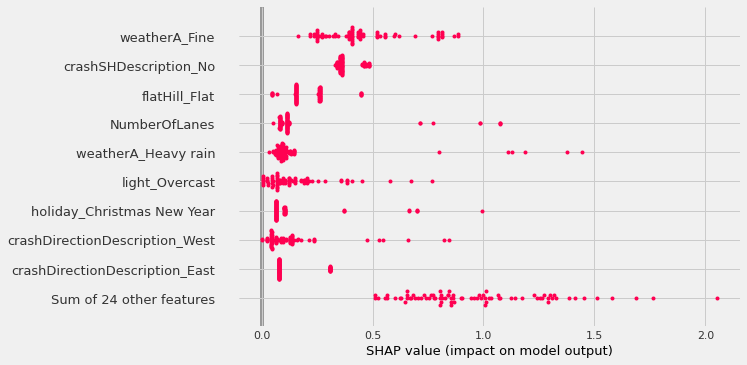

In [124]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

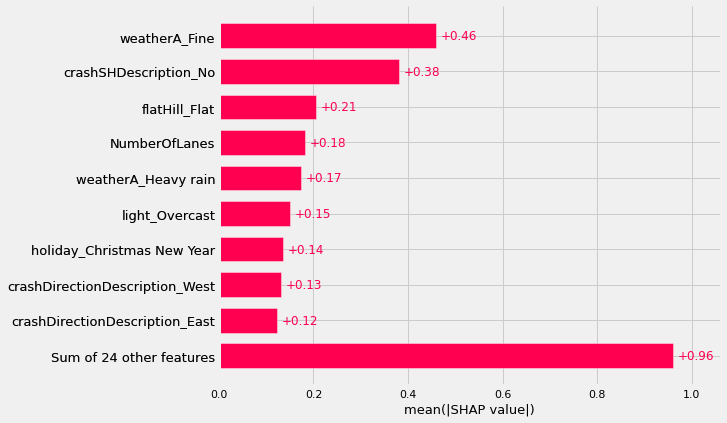

In [125]:
shap.plots.bar(shap_values.abs.mean(0))

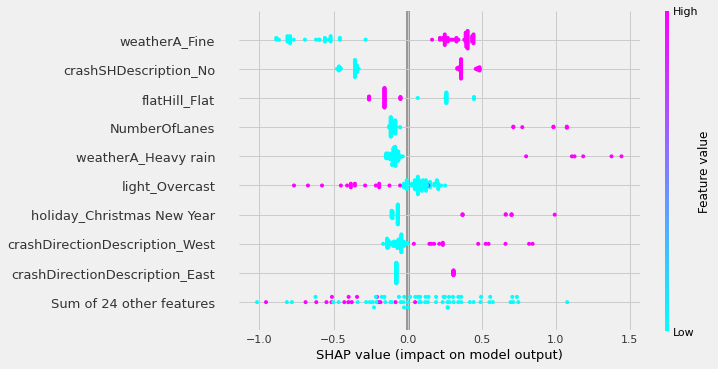

In [126]:
import matplotlib.pyplot as plt
shap.plots.beeswarm(shap_values, color=plt.get_cmap("cool"))